In [63]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
import numpy as np

!pip install wandb
import wandb
from wandb.keras import WandbCallback

from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = "drive/MyDrive/nature_12K.zip"
!cp "{zip_path}" .
!unzip -q nature_12K.zip
!rm nature_12K.zip

In [4]:
## Automate the building of CNN
def createCNN(num_filters=32, filter_multiplier=1, dropout=0.2, batch_norm=False, dense_size=64, num_classes=10):
    model = Sequential()
    
    for i in range(5):
        filter_dim = 11 - 2*i
        filter_size = (filter_dim, filter_dim)
        model.add(Conv2D(num_filters, filter_size))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        num_filters = int(num_filters * filter_multiplier)
    
    model.add(Flatten())
    model.add(Dense(dense_size))
    model.add(Dropout(dropout))
    model.add(Activation("relu"))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))

    return model;

In [5]:
## Prepare the dataset for training
def prepare_dataset(DATA_DIR="inaturalist_12K", augment_data=False):
    train_dir = os.path.join(DATA_DIR, "train")
    test_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)

    else:
        train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
        test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256, subset="training")
    val_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256, subset="validation")
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(200, 200), batch_size=256)
    
    return train_generator, val_generator, test_generator;

In [6]:
def setRunName(num_filters=32, filter_multiplier=1, augment_data=False, dropout=0.2, batch_norm=False):
    
    augment_data_options = {True: "Y", False: "N"}
    batch_norm_options = {True: "Y", False: "N"}

    run_name = "_".join(["num", str(num_filters), "org", str(filter_multiplier), "aug", augment_data_options[augment_data],
                      "drop", str(dropout), "norm", batch_norm_options[batch_norm]])
    
    return run_name;

In [7]:
def train():

    config_defaults = {
        "num_filters": 32,
        "filter_multiplier": 2,
        "augment_data": False,
        "dropout": 0.3,
        "batch_norm": False,
        "epochs": 10,
        "dense_size": 64,
        "lr": 0.001
    }

    wandb.init(config=config_defaults, magic=True)
    config = wandb.config
    wandb.run.name = setRunName(config.num_filters, config.filter_multiplier, config.augment_data, config.dropout, config.batch_norm)

    train_generator, val_generator, test_generator = prepare_dataset(augment_data=config.augment_data)
    model = createCNN(num_filters=config.num_filters, filter_multiplier=config.filter_multiplier,
                      dropout=config.dropout, batch_norm=config.batch_norm, dense_size=config.dense_size)
    model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, validation_data=val_generator, callbacks=[WandbCallback()])

In [8]:
def prepare_test_dataset(DATA_DIR="inaturalist_12K", augment_data=False):
    train_dir = os.path.join(DATA_DIR, "train")
    test_dir = os.path.join(DATA_DIR, "val")

    if augment_data:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          horizontal_flip=True)
        test_datagen = ImageDataGenerator(rescale=1./255)

    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(200, 200), batch_size=256)
    test_generator = test_datagen.flow_from_directory(test_dir, target_size=(200, 200), batch_size=30)
    
    return train_generator, test_generator;

In [80]:
def plot_test_results(test_data, predictions, labels):
    fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(15,15))
    output_map = {0: 'Amphibia', 1: 'Animalia', 2: 'Arachnida', 3: 'Aves', 4: 'Fungi', 
                  5: 'Insecta', 6: 'Mammalia', 7: 'Mollusca', 8: 'Plantae', 9: 'Reptilia'}
    for i in range(30):
        img = test_data[0][0][i]
        ax[int(i/6), i%6].imshow(img)
        ax[int(i/6), i%6].axis('off')
        ax[int(i/6), i%6].set_aspect('equal')
        ax[int(i/6), i%6].set_title("Predicted: " + output_map[np.argmax(predictions, axis=1)[i]] + "\nLabel: " + output_map[np.argmax(labels, axis=1)[i]])

In [79]:
def plot_filters(model, test_data, sample_num):
    sub_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    plt.imshow(test_data[0][0][sample_num])
    plt.axis('off')
    feature_maps = sub_model(test_data[0][0])
    fig, ax = plt.subplots(4, 8, figsize=(12,6))
    for i in range(feature_maps.shape[-1]):
        ax[int(i/8), i%8].imshow(feature_maps[sample_num, :, :, i], cmap='gray')
        ax[int(i/8), i%8].axis('off')

In [78]:
def test():

    config_defaults = {
        "num_filters": 32,
        "filter_multiplier": 2,
        "augment_data": True,
        "dropout": 0.3,
        "batch_norm": True,
        "epochs": 10,
        "dense_size": 64,
        "lr": 0.001
    }

    wandb.init(config=config_defaults, magic=True)
    config = wandb.config
    wandb.run.name = setRunName(config.num_filters, config.filter_multiplier, config.augment_data, config.dropout, config.batch_norm)

    train_generator, test_generator = prepare_test_dataset(augment_data=config.augment_data)
    model = createCNN(num_filters=config.num_filters, filter_multiplier=config.filter_multiplier,
                      dropout=config.dropout, batch_norm=config.batch_norm, dense_size=config.dense_size)
    model.compile(optimizer=keras.optimizers.Adam(config.lr), loss="categorical_crossentropy", metrics="categorical_accuracy")
    model.fit(train_generator, epochs=config.epochs, callbacks=[WandbCallback()])

    print("Evaluating Model:")
    model.evaluate(test_generator, batch_size=256)
    predictions = model(test_generator[0][0])
    plot_test_results(test_generator, predictions, test_generator[0][1])
    sample_num = 11
    plot_filters(model, test_generator, sample_num)

In [81]:
sweep_config = {
    "name": "Test the output of Model",
    "description": "Checking the performance of CNN on sample of test data",
    "metric": "Val Accuracy",
    "method": "grid",
    "project": "CS6910_Assignment2",
    "parameters": {
        "num_filters": {
            "values": [32]
        },
        "filter_multiplier": {
            "values": [2]
        },
        "augment_data": {
            "values": [True]
        },
        "dropout": {
            "values": [0.3]
        },
        "batch_norm": {
            "values": [True]
        },
        "epochs": {
            "values": [1]
        },
        "dense_size": {
            "values": [64]
        },
        "lr": {
            "values": [0.001]
        },
        "epochs": {
            "values": [10]
        }
    }
}

# creating the sweep
sweep_id = wandb.sweep(sweep_config, project="CS6910_Assignment2")

Create sweep with ID: 0swy0t66
Sweep URL: https://wandb.ai/avyay/cs6910_assignment2/sweeps/0swy0t66


wandb: Agent Starting Run: vld5empr with config:
wandb: 	augment_data: True
wandb: 	batch_norm: True
wandb: 	dense_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_multiplier: 2
wandb: 	lr: 0.001
wandb: 	num_filters: 32


Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
40/40 [==============================] - 237s 6s/step - loss: 2.5276 - categorical_accuracy: 0.1349
Epoch 2/10
40/40 [==============================] - 236s 6s/step - loss: 2.2537 - categorical_accuracy: 0.1567
Epoch 3/10
40/40 [==============================] - 238s 6s/step - loss: 2.2405 - categorical_accuracy: 0.1501
Epoch 4/10
40/40 [==============================] - 238s 6s/step - loss: 2.2363 - categorical_accuracy: 0.1792
Epoch 5/10
40/40 [==============================] - 238s 6s/step - loss: 2.2352 - categorical_accuracy: 0.1787
Epoch 6/10
40/40 [==============================] - 236s 6s/step - loss: 2.2001 - categorical_accuracy: 0.1949
Epoch 7/10
40/40 [==============================] - 234s 6s/step - loss: 2.2064 - categorical_accuracy: 0.1901
Epoch 8/10
40/40 [==============================] - 233s 6s/step - loss: 2.1989 - categorical_accuracy: 0.2059
Epoch 9/10
40/40 [========

epoch,9
loss,2.16098
categorical_accuracy,0.21462
_runtime,2367
_timestamp,1617977935
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▄▂▃▂▁▁
categorical_accuracy,▁▂▃▄▄▆▆▇▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


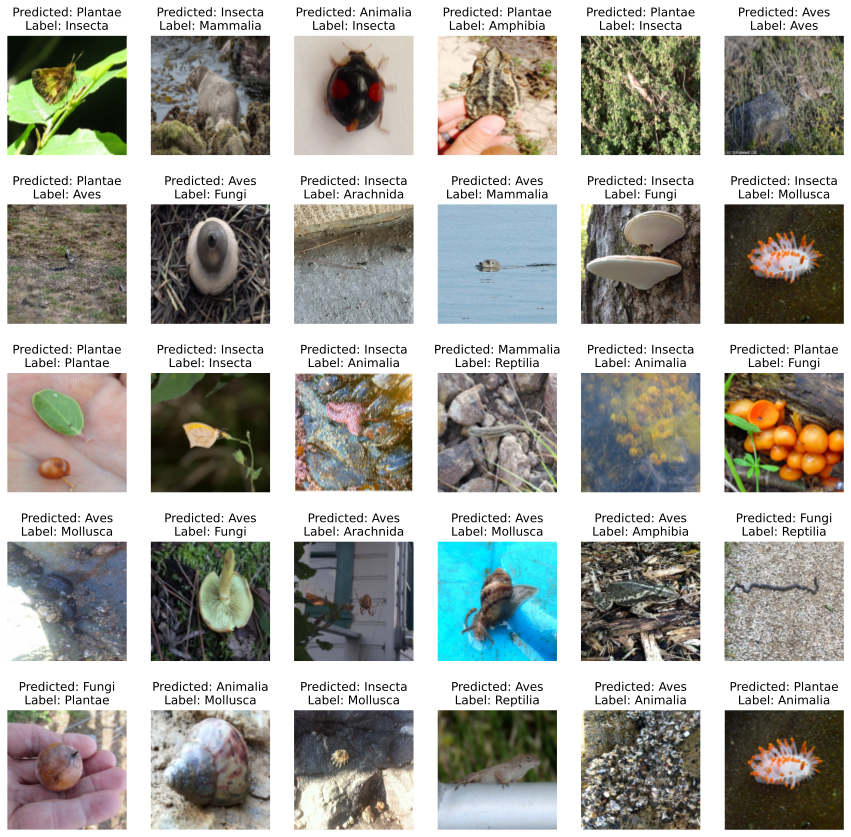

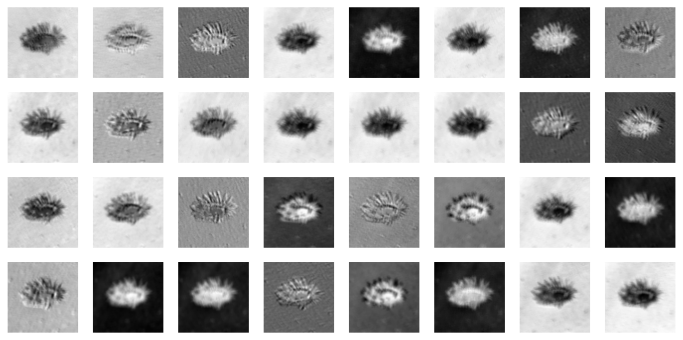

In [82]:
wandb.agent(sweep_id, function=test)